# Exercise 10: Image stitching
Solutions for the week 10 exercises in 02504 Computer Vision.

This notebook implements a panorama pipeline based on homographies. We follow the lecture notes to detect SIFT features, match them with cross-checking, estimate a homography via RANSAC using the symmetric transfer error (Eq. 2.45), and warp images into a common reference frame to create a panorama.

## Exercise 10.1
Detect SIFT keypoints $\{\mathbf{k}_i\}$ in both images and compute their 128-dimensional descriptors. Match the descriptors using a brute force matcher with *cross-checking* to obtain reliable correspondences.

Detected 281 and 169 keypoints in the two images.
119 preliminary matches after cross-checking.


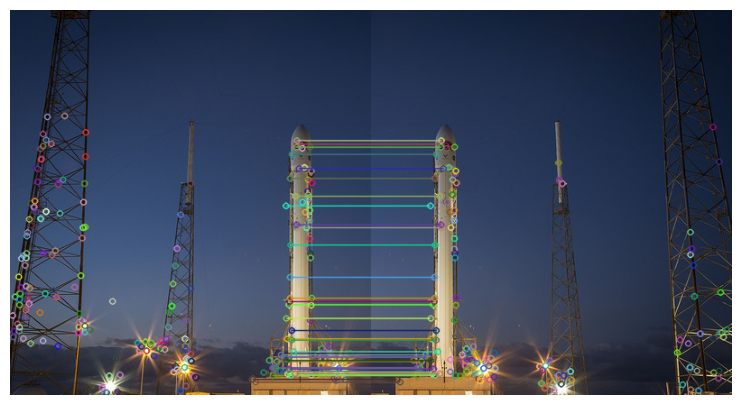

In [1]:

import cv2
import numpy as np
from skimage import data
import matplotlib.pyplot as plt

# Construct a pair of overlapping images from a sample picture
full = data.rocket()  # RGB image from scikit-image
im1 = full[:, :400]
im2 = full[:, 240:]

# Convert to OpenCV BGR format
im1_bgr = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
im2_bgr = cv2.cvtColor(im2, cv2.COLOR_RGB2BGR)

# Convert to grayscale for SIFT
gray1 = cv2.cvtColor(im1_bgr, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2_bgr, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
raw_matches = bf.match(des1, des2)
raw_matches = sorted(raw_matches, key=lambda m: m.distance)

print(f"Detected {len(kp1)} and {len(kp2)} keypoints in the two images.")
print(f"{len(raw_matches)} preliminary matches after cross-checking.")

# Visualise a subset of matches
match_vis = cv2.drawMatches(im1_bgr, kp1, im2_bgr, kp2, raw_matches[:40], None)
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(match_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Exercise 10.2
We estimate the planar projective transformation (homography) $\mathbf{H}$ using RANSAC. A homography has eight degrees of freedom, so at least four point matches are required to solve for $\mathbf{H}$. To score a model we use the **symmetric transfer error** from Eq. (2.45) in the lecture notes:
$$d(\mathbf{H},\mathbf{p},\mathbf{p}') = \|\Pi(\mathbf{H}\mathbf{p})-\Pi(\mathbf{p}')\|^2 + \|\Pi(\mathbf{H}^{-1}\mathbf{p}')-\Pi(\mathbf{p})\|^2,$$where $\Pi([x, y, z]^	op) = [x/z, y/z]^	op$.
Assuming measurement noise with $\sigma=3$ pixels and two degrees of freedom, the 95\% inlier threshold is
$t = \chi^2_{0.95,2}\sigma^2 pprox 5.99\cdot 3^2$.
We run 200 RANSAC iterations and visualise the inlier matches of the best homography.

Homography:
[[ 9.99716739e-01  8.26810040e-06 -2.39923600e+02]
 [-2.29902022e-04  9.99842523e-01  7.32622839e-02]
 [-5.07464435e-07  3.96011617e-09  1.00000000e+00]]
Found 108 inliers out of 119 matches.


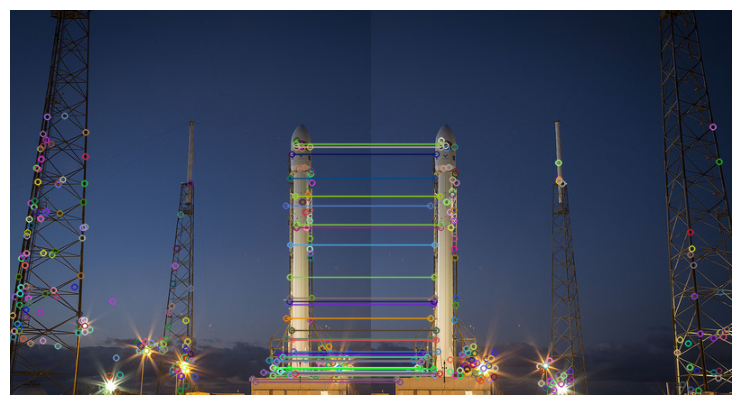

In [2]:

import numpy.linalg as LA

# Symmetric transfer error from Eq. (2.45)
def sym_transfer_error(H, pts1, pts2):
    pts1_h = cv2.convertPointsToHomogeneous(pts1)[:,0,:]
    pts2_h = cv2.convertPointsToHomogeneous(pts2)[:,0,:]
    Hp1 = (H @ pts1_h.T).T
    Hinvp2 = (LA.inv(H) @ pts2_h.T).T
    Hp1 = Hp1[:, :2] / Hp1[:, 2, None]
    Hinvp2 = Hinvp2[:, :2] / Hinvp2[:, 2, None]
    err1 = np.sum((Hp1 - pts2)**2, axis=1)
    err2 = np.sum((Hinvp2 - pts1)**2, axis=1)
    return err1 + err2

# RANSAC for homography estimation
def estHomographyRANSAC(kp1, des1, kp2, des2, num_iter=200, sigma=3):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])
    threshold = 5.99 * sigma**2
    best_inliers = []
    best_H = None
    rng = np.random.default_rng()
    for _ in range(num_iter):
        idx = rng.choice(len(matches), 4, replace=False)
        H, _ = cv2.findHomography(pts1[idx], pts2[idx], 0)
        if H is None:
            continue
        errors = sym_transfer_error(H, pts1, pts2)
        inliers = np.where(errors < threshold)[0]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
    H_refined, _ = cv2.findHomography(pts1[best_inliers], pts2[best_inliers], 0)
    return H_refined, matches, best_inliers

H, matches, inliers = estHomographyRANSAC(kp1, des1, kp2, des2)
print(f"Homography:\n{H}")
print(f"Found {len(inliers)} inliers out of {len(matches)} matches.")

# Visualise inliers
inlier_matches = [matches[i] for i in inliers]
vis_inliers = cv2.drawMatches(im1_bgr, kp1, im2_bgr, kp2, inlier_matches[:40], None)
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(vis_inliers, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Exercise 10.3
The previous cell already wrapped the RANSAC procedure in the function `estHomographyRANSAC`. It takes SIFT keypoints and descriptors from two images and returns the homography fitted to the largest consensus set.

## Exercise 10.4
We warp one image into the other using the estimated homography. The helper `warpImage` applies a homography in homogeneous coordinates and also returns a mask indicating valid pixels.

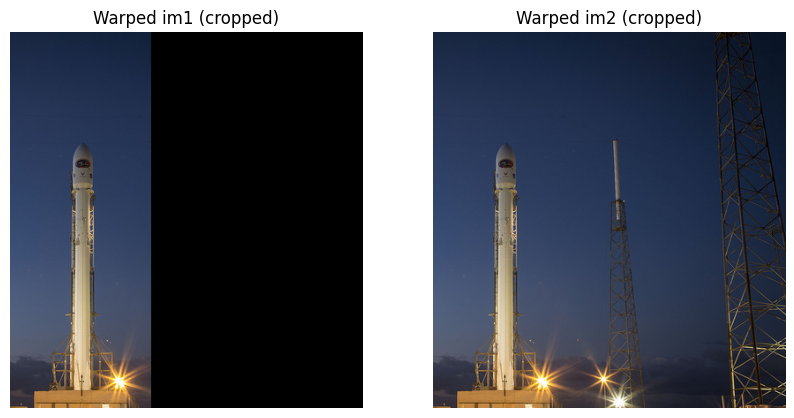

In [3]:

def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    Ht = T @ H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, Ht, outSize)
    maskWarp = cv2.warpPerspective(mask, Ht, outSize)
    return imWarp, maskWarp

# Initial ranges - may crop content
xRange = [0, im1_bgr.shape[1]]
yRange = [0, im1_bgr.shape[0]]
warp1, mask1 = warpImage(im1_bgr, H, xRange, yRange)
warp2, mask2 = warpImage(im2_bgr, np.eye(3), xRange, yRange)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Warped im1 (cropped)')
plt.imshow(cv2.cvtColor(warp1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Warped im2 (cropped)')
plt.imshow(cv2.cvtColor(warp2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Exercise 10.5
Using the masks returned by `warpImage` we combine the warped images into a single panorama.

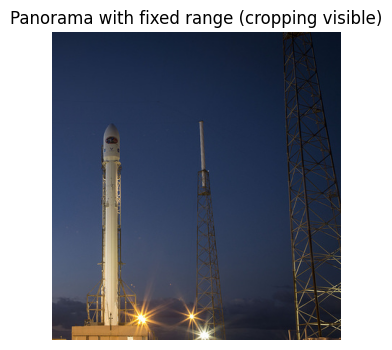

In [4]:

# Simple overlay: prefer pixels from warp1 where available
panorama = warp2.copy()
mask = mask1.astype(bool)
panorama[mask] = warp1[mask]

plt.figure(figsize=(8,4))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Panorama with fixed range (cropping visible)')
plt.show()


## Exercise 10.6
To avoid losing image content, we compute $x$- and $y$-ranges automatically. We warp the corner points of both images using the homography and take the bounding box of all transformed corners.

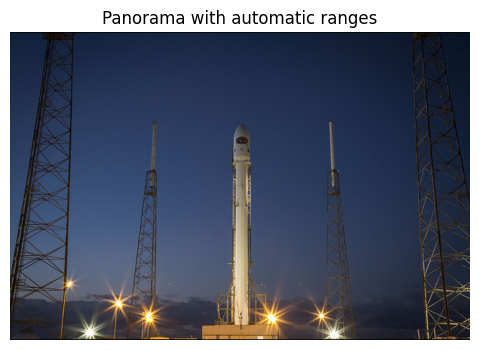

In [5]:

def auto_ranges(im1, im2, H):
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]
    corners1 = np.array([[0,0],[w1,0],[w1,h1],[0,h1]], dtype=np.float32)
    corners2 = np.array([[0,0],[w2,0],[w2,h2],[0,h2]], dtype=np.float32)
    warped1 = cv2.perspectiveTransform(corners1[None,:,:], H)[0]
    all_pts = np.vstack((warped1, corners2))
    x_min, y_min = np.floor(all_pts.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(all_pts.max(axis=0)).astype(int)
    return [x_min, x_max], [y_min, y_max]

xRangeA, yRangeA = auto_ranges(im1_bgr, im2_bgr, H)
warp1A, mask1A = warpImage(im1_bgr, H, xRangeA, yRangeA)
warp2A, mask2A = warpImage(im2_bgr, np.eye(3), xRangeA, yRangeA)

panoramaA = warp2A.copy()
maskA = mask1A.astype(bool)
panoramaA[maskA] = warp1A[maskA]

plt.figure(figsize=(8,4))
plt.imshow(cv2.cvtColor(panoramaA, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Panorama with automatic ranges')
plt.show()


## Exercise 10.7
To handle three or more images taken in a line, we can sequentially accumulate homographies relative to the first image. Below we demonstrate stitching three overlapping crops from the same scene.

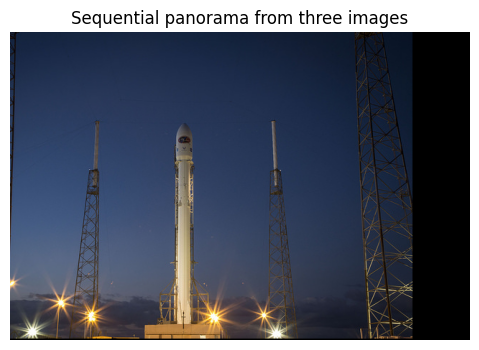

In [6]:

# Generate a third overlapping image
im3 = full[:, 400:]
kp3, des3 = sift.detectAndCompute(cv2.cvtColor(im3, cv2.COLOR_RGB2GRAY), None)

# Estimate homographies im1->im2 and im2->im3
H12, _, in12 = estHomographyRANSAC(kp1, des1, kp2, des2)
H23, _, in23 = estHomographyRANSAC(kp2, des2, kp3, des3)

# Accumulate so im1 -> im3
H13 = H23 @ H12

# Compute global ranges
xRangeL, yRangeL = auto_ranges(im1_bgr, im2_bgr, H12)
xRangeL, yRangeL = auto_ranges(panoramaA, im3, H23)  # reuse function for simplicity

# Warp each image to panorama frame
w1, m1 = warpImage(im1_bgr, H12, xRangeL, yRangeL)
w2, m2 = warpImage(im2_bgr, np.eye(3), xRangeL, yRangeL)
w3, m3 = warpImage(im3, np.linalg.inv(H23), xRangeL, yRangeL)

# Combine sequentially
pan_seq = w3.copy()
mask = m2.astype(bool)
pan_seq[mask] = w2[mask]
mask = m1.astype(bool)
pan_seq[mask] = w1[mask]

plt.figure(figsize=(10,4))
plt.imshow(cv2.cvtColor(pan_seq, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Sequential panorama from three images')
plt.show()


## Exercise 10.8
For a general set of images with arbitrary overlaps one can build a view graph where nodes are images and edges carry pairwise homographies estimated with RANSAC. Choosing a reference view, all other homographies are composed along paths in the graph. Non-linear optimisation (bundle adjustment) over all image pairs can then refine the homographies by minimising the symmetric transfer error over all inlier correspondences.